# Logistic Regression #

## Lab 04 : Logistic Regression with Iris Dataset ##

### Review ###  

**모델(Model)**
Logistic Func : $y=\frac{1}{1+e^-(Wx+b)}$  
Softmax Func  : $y_i=\frac{e^{W_i+b_i}}{\sum_je^{W_j+b_j}}$  

**모수(Parameter)**  
$W$ : Weight  
$b$ : bias  

**오차 함수(Error Function)**  
Cross Entropy : $L = -\sum_i \hat{y}_ilog(y_i)$  

### Load Iris Dataset ###
학습을 하기 위해서는 데이터셋을 불러와야합니다.  
오늘 우리가 사용할 데이터셋은 매우 유명한 데이터셋이기 때문에 간단한 라이브러리를 통해서도 다운받을 수 있습니다.  

사용할 데이터셋의 이름은 **Iris Dataset**이라 불립니다.  
우리말로 하면 붓꽃이죠.  

이 Iris의 종은 3가지로 나뉜다 하는데, 각각 **Iris Versicolor, Iris Setosa, Iris Virginica**로 나뉩니다.  
Iris Dataset은 이 세가지 종의 꽃받침, 꽃잎의 길이와 너비 데이터가 있습니다.  
이 길이와 너비 데이터를 활용한다면 Iris의 종을 분류할 수 있다고 합니다.  

우선 `sklearn`이라는 라이브러리를 통해 iris 데이터셋을 불러와보도록 할게요.  
Sci-kit Learn이라고 부르는 이 라이브러리는 머신러닝 학습에 도움이 되는 코드들을 많이 가지고 있습니다.  
그럼 시작해보록 하겠습니다!

In [1]:
# 필요한 라이브러리들을 import 해보겠습니다.
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
import imageio

In [2]:
# 데이터셋을 불러와볼게요.
iris_dataset = load_iris()

In [3]:
# Description을 한번 볼까요?
print(iris_dataset['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [4]:
# 어떤 데이터가 있는지 볼게요.
print(iris_dataset.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])


iris 데이터셋을 불러왔습니다! 여기서,  
**data**는 우리가 사용할 Sepal Length&Width, Petal Length&Width 데이터가 담겨있고,  
**target**는 그 data가 어떤 Category에 속해있는지 0, 1, 2로 구분되게 됩니다.  

데이터를 눈으로 봐야 어떤느낌인지 알겠죠?  
시각화해보겠습니다.

In [5]:
X = iris_dataset['data']
Y = iris_dataset['target']

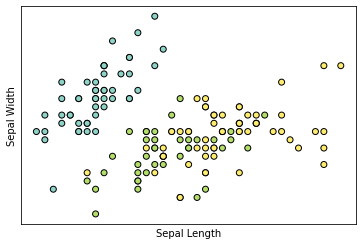

In [6]:
plt.figure(1)
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Set3)
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.xticks(())
plt.yticks(())
plt.show()

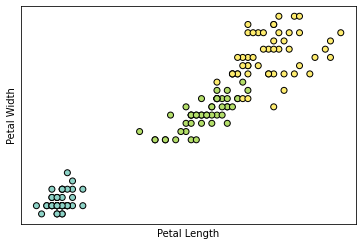

In [7]:
plt.figure(1)
plt.scatter(X[:, 2], X[:, 3], c=Y, edgecolors='k', cmap=plt.cm.Set3)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.xticks(())
plt.yticks(())
plt.show()

자, 그러면 이 데이터를 학습하기 쉽게 해주는 `Dataset`라는 것을 구현해볼게요.  
PyTorch의 Dataset Class는 이렇게 구성됩니다.  
```python
# data.Dataset을 상속하는 Dataset 클래스를 구현합니다.
class MyDataset(data.Dataset):
    def __init__(self):
        super(MyDataset, self).__init__()
        # 이곳에 데이터셋이 생성될 때 필요한 코드를 작성해줍니다.
        
    def __len__(self):
        # 이곳에 데이터셋의 길이를 반환하는 함수를 구현합니다.
        return some_variable_of_length
    
    def __getitem__(self, index):
        # Index가 주어졌을 때 그 위치의 데이터를 반환하는 코드를 구현합니다.
        return some_item_array[index]
```

이렇게 Dataset을 Dataset 함수로 감싸면 차후 데이터 분산처리, Batch 학습 등에 편리하게 사용될 수 있습니다.  
Iris Dataset도 이렇게 감싸보겠습니다. 우리는 일단 간단하게 학습이 되는지 알아보기 위해 Sepal 정보만 활용해볼게요.

In [8]:
class IrisDataset(data.Dataset):
    def __init__(self):
        super(IrisDataset, self).__init__()
        
        iris = load_iris()
        self.X, self.y =  iris.data, iris.target
        self.X = self.X[:,0:2]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        data = torch.Tensor(self.X[index])
        label = torch.LongTensor([self.y[index]])
        return data, label

In [9]:
dataset = IrisDataset()
first_data, first_label = dataset[0]
print("First Data :", first_data)
print("First Label:", first_label)

First Data : tensor([5.1000, 3.5000])
First Label: tensor([0])


이렇게 첫 데이터셋을 만들었습니다.  
PyTorch는 이렇게 만들어진 Dataset을 불러올 수 있는 Interface를 제공합니다.  
`DataLoader`라고 불리는 이 Interface는 data를 자동으로 랜덤하게 섞어주거나, Data를 더 빠르게 불러오기 위해 여러개의 Thread를 사용하게끔 하는 등 편리한 기능들을 제공합니다.  
그러면, 이 DataLoader를 통해서 우리의 IrisDataset을 불러와보도록 할게요.

In [10]:
data_loader = data.DataLoader(dataset, shuffle=True)

In [11]:
for x, y in data_loader:
    print("X:", x)
    print("Y:", y)
    break

X: tensor([[5., 2.]])
Y: tensor([[1]])


`Dataset`, `DataLoader`까지 구현을 했으니, 이제 PyTorch로 모델을 구현해볼게요.  
PyTorch는 아래와 같은 클래스를 통해서 모델을 구현할 수 있습니다.

```python
# nn.Module을 상속하는 Model 클래스를 구현합니다.
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # 이곳에 모델이 필요한 모듈들이나, 변수들을 선언해줍니다.
        self.fc1 = nn.Linear(#Input_Size, #Output_Size)
        self.sigmoid = nn.Sigmoid()
            
    def forward(self, x):
        # 이곳에 모델을 호출했을 때, 데이터가 어떻게 흘러가도록 할건지 구현해줍니다.
        x = self.fc1(x)
        x = self.sigmoid(x)
        
        return x
```

자, 그럼 Softmax Regression을 직접 구현해볼게요.  
참고로 PyTorch에서는 Softmax Function을 따로 사용해줄 필요가 없습니다!  
PyTorch의 Cross Entropy Loss에는 Multi-Label Classification을 고려하여 Softmax 함수가 포함되어 있습니다.  
결국에는 모델의 Input과 Output은 이렇게 되겠지요.  

**Input**  
Data  : `[sepal_length, sepal_width]`  
Shape : `(2,)`  

**Output**
Data : `[Class0 Probability, Class1 Probability, Class2 Probability]`  
Shape : `(3,)`

이를 참고하여 모델을 구현해보겠습니다.

In [12]:
class SoftmaxRegressionModel(nn.Module):
    def __init__(self):
        super(SoftmaxRegressionModel, self).__init__()
        self.linear = nn.Linear(2, 3)
        
    def forward(self, x):
        x = self.linear(x)
        return x

In [13]:
model = SoftmaxRegressionModel()
model(torch.FloatTensor([1, 2]))

tensor([-0.5696,  0.1024, -1.2020], grad_fn=<AddBackward0>)

예상대로 (4,)의 Shape를 가진 Data가 들어갔을 때, (3,)의 Class Probability들이 나왔습니다.  
그러면, 이 모델을 가지고 학습 전, 현재 이 모델이 어떻게 분류를 하고 있는지 한번 볼게요.

/home/fylsunghwan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


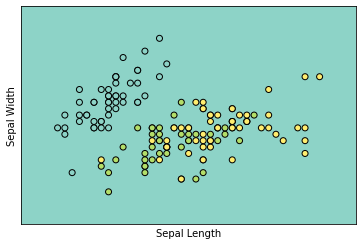

In [14]:
def visualize(X, Y, model, save_idx=None, device='cuda'):
    sepalL_min, sepalL_max = X[:, 0].min() - .5, X[:, 0].max() +.5
    sepalW_min, sepalW_max = X[:, 1].min() - .5, X[:, 1].max() +.5

    ar_L, ar_W = np.meshgrid(np.arange(sepalL_min, sepalL_max, .02),
                             np.arange(sepalW_min, sepalW_max, .02))

    input_arange = np.array([ar_L.ravel(), ar_W.ravel()])
    input_arange = input_arange.T
    Z = model(torch.FloatTensor(input_arange).to(device)).detach().cpu().numpy()
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(ar_L.shape)
    
    plt.figure(1)
    plt.pcolormesh(ar_L, ar_W, Z, cmap=plt.cm.Set3)
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Set3)
    plt.xlabel('Sepal Length')
    plt.ylabel('Sepal Width')
    plt.xlim(ar_L.min(), ar_L.max())
    plt.ylim(ar_W.min(), ar_W.max())
    plt.xticks(())
    plt.yticks(())
    
    if save_idx != None:
        if not os.path.exists("gifs"):
            os.mkdir("gifs")
        plt.savefig("gifs/" + str(save_idx).zfill(5) + ".png")
    else:
        plt.show()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
visualize(X, Y, model, device)

자, 그럼 학습을 시작해볼게요.  
GradientDescent를 수행해주는 `SGD` 말고 이번에는 `Adam` Optimizer를 사용해볼게요.  
Adam Optimizer는 SGD와 비슷하지만, 성능이 더 좋답니다.  

/home/fylsunghwan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


EPOCH[1|600] loss: 2.28
EPOCH[101|600] loss: 0.82
EPOCH[201|600] loss: 0.79
EPOCH[301|600] loss: 0.80
EPOCH[401|600] loss: 0.81
EPOCH[501|600] loss: 0.49


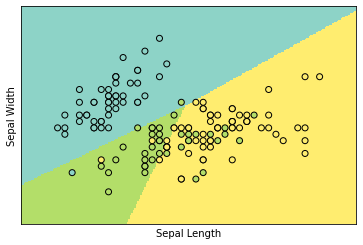

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SoftmaxRegressionModel().to(device)
criterion = nn.CrossEntropyLoss()
dataset = IrisDataset()
dataloader = data.DataLoader(dataset, batch_size=16, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epoch = 600
losses = []
for epoch in range(n_epoch):
    for x, y in dataloader:
        # Data to GPU
        x = x.to(device)
        y = y.squeeze(-1).to(device)
        
        # Initialize Optimizer
        optimizer.zero_grad()
        
        # Model Inference
        y_hat = model(x)
        
        # Get Loss
        loss = criterion(y_hat, y)
        
        # Logging
        losses.append(loss.detach().cpu().item())
        
        # Back Propagation
        loss.backward()
        
        # Weight Update
        optimizer.step()
    
    if epoch%100 == 0:
        print('EPOCH[{current}|{total}] loss: {loss:.2f}'.format(
            current=epoch+1,
            total=n_epoch,
            loss=loss.detach().cpu().item()
        ))
    
    if epoch%10 == 0:
        with torch.no_grad():
            visualize(X, Y, model, save_idx=epoch//10, device=device)

자, 학습이 완료되었습니다!  
학습이 되는동안 loss가 어떻게 떨어졌는지 Visualize해볼게요.

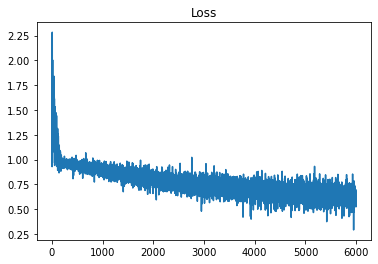

In [19]:
plt.plot(losses)
plt.title("Loss")
plt.show()

Loss가 잘 떨어지는 것을 확인하실 수 있습니다!  
자 그러면 모델이 어떻게 학습했는지 Visualize를 해볼게요.

/home/fylsunghwan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


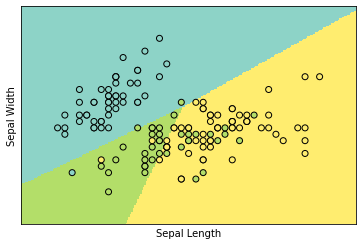

In [20]:
visualize(X, Y, model, device=device)

학습 과정도 한번 볼게요!

100%|██████████| 61/61 [00:00<00:00, 105.97it/s]


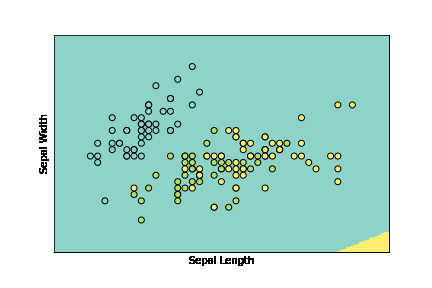

In [18]:
gifs = os.listdir("gifs")
gifs.sort()
with imageio.get_writer('train.gif', mode='I') as writer:
    for filename in tqdm(gifs):
        image = imageio.imread("gifs/"+filename)
        writer.append_data(image)

from IPython.display import Image
Image(filename="train.gif")

## 수고하셨습니다